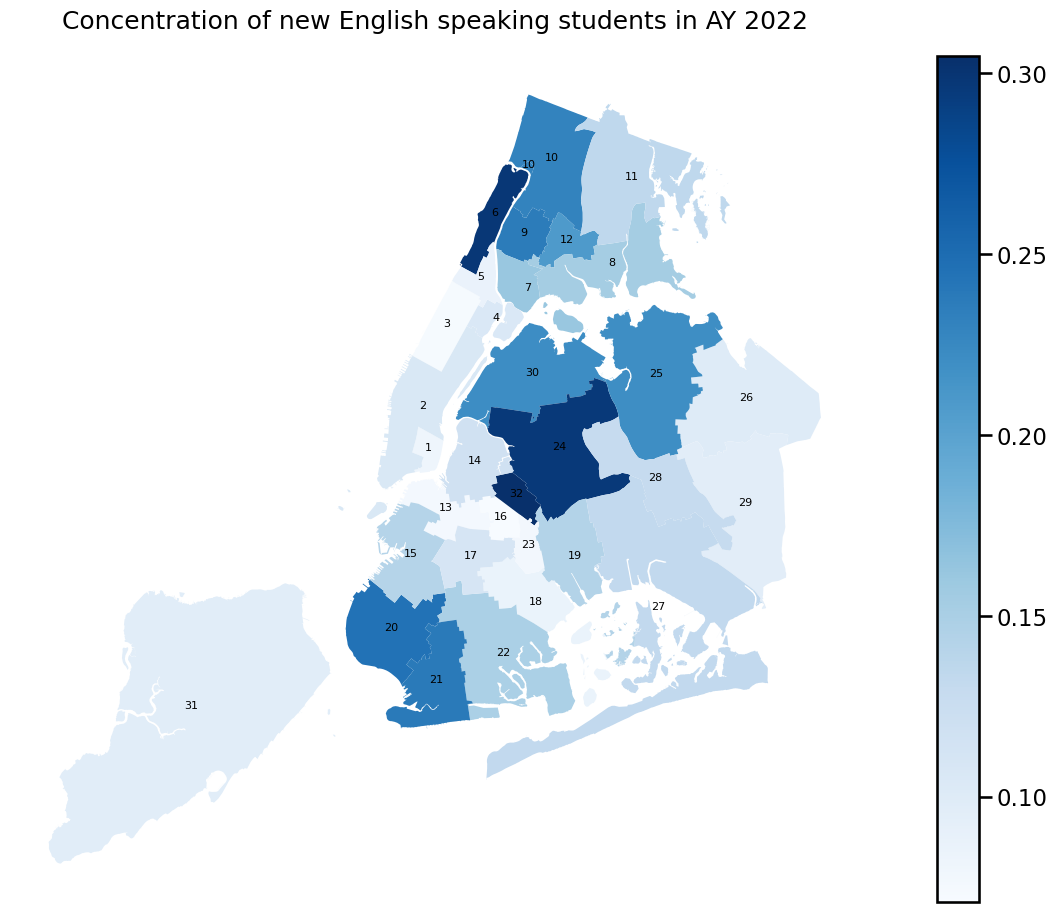

In [5]:
# make a district map with matplotlib
from nycschools import schools, geo, ui
import matplotlib.pyplot as plt
import seaborn as sns
# get the data we need using nycschools
districts = geo.load_districts()
df = schools.load_school_demographics()

# use only the most recent year in our data set
latest_ay = df.ay.max()
df = df[df.ay == latest_ay]


key_col = "ell_pct"
ell = df.groupby("district").agg({key_col: "mean"}).reset_index()
data = districts.merge(ell, on="district", how="inner")

fig, ax = plt.subplots(figsize=(16, 9))
sns.set_context('talk')

# don't show the boundary box or x/y ticks
plt.axis('off')
fig.tight_layout()
ax.set_title(f'Concentration of new English speaking students in AY {latest_ay}', pad=20)

# write the district numbers on the map at the center of the district shape
def label(row):
    xy = row.geometry.centroid.coords[0]
    ax.annotate(row.district, xy=xy, ha='center', fontsize=8)


data.apply(label, axis=1)

# plot districts, hide the axis labels, use the title "District % Poverty"
_ = data.plot(ax=ax, column=key_col, cmap="Blues", legend=True)

In [8]:
# get the data we need using nycschools
districts = geo.load_districts()
df = schools.load_school_demographics()
df.ay.unique()

array([2016, 2018, 2019, 2020, 2021, 2022])

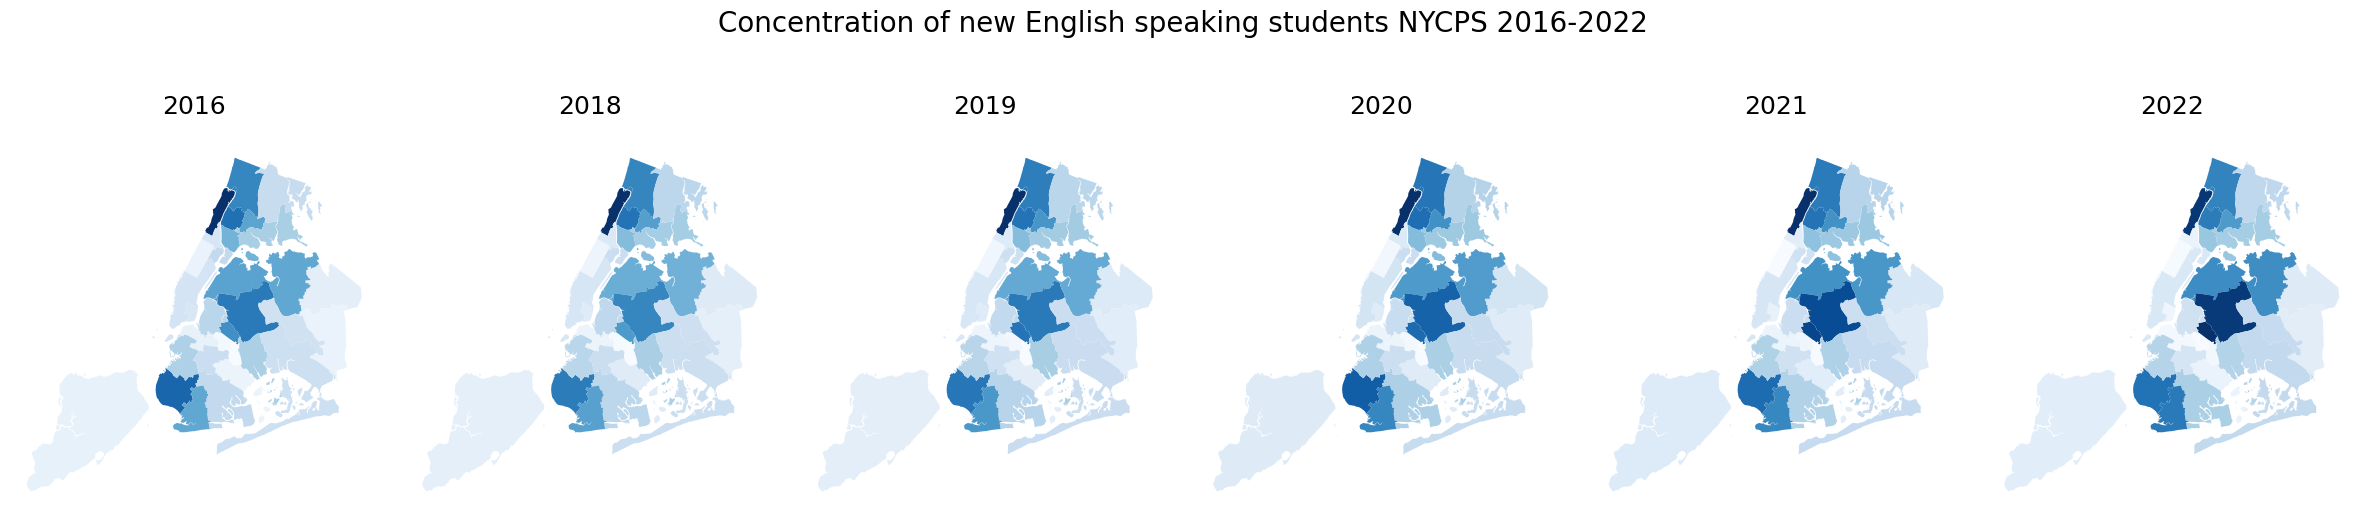

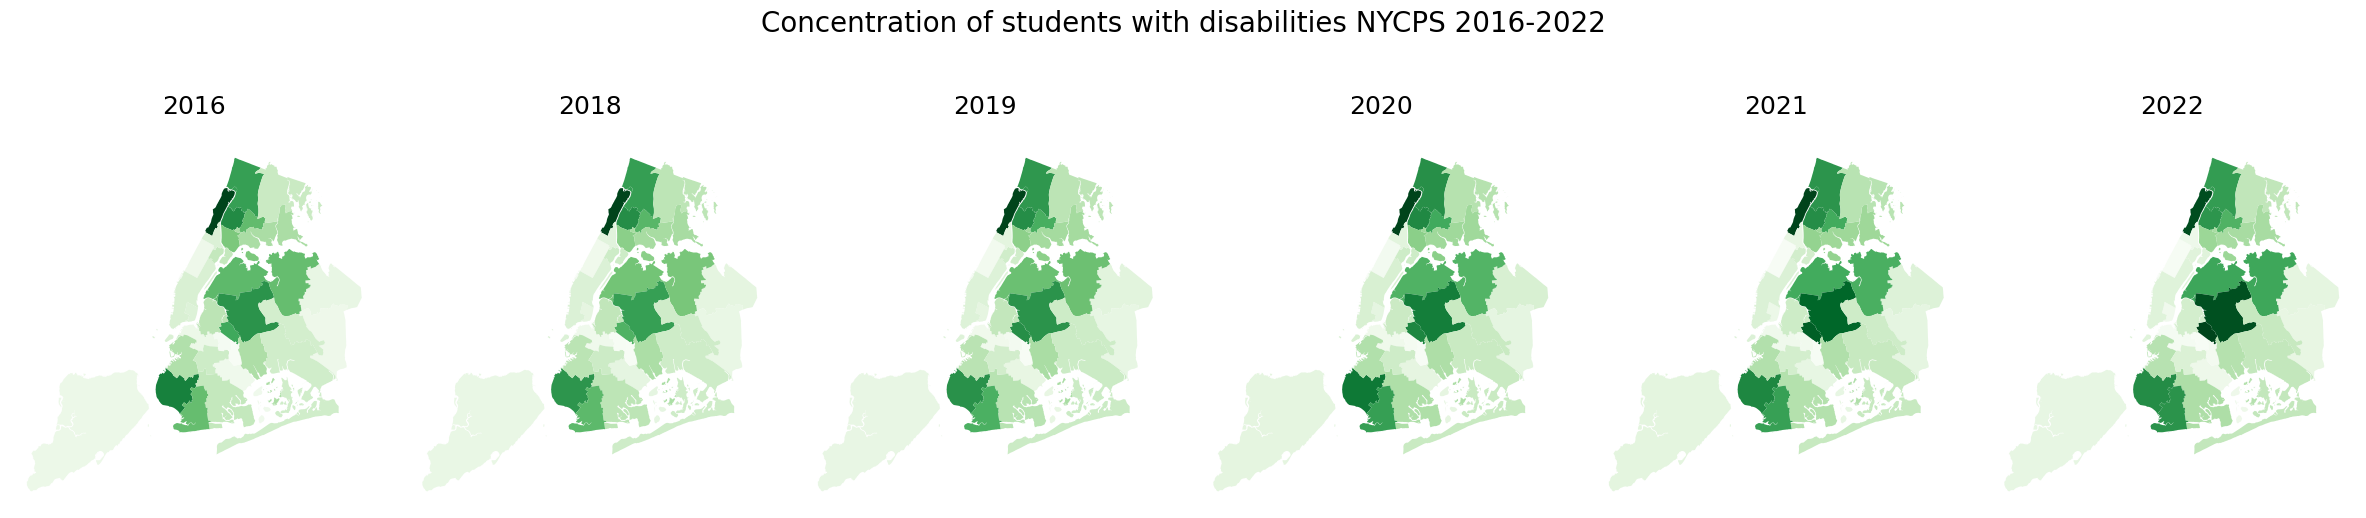

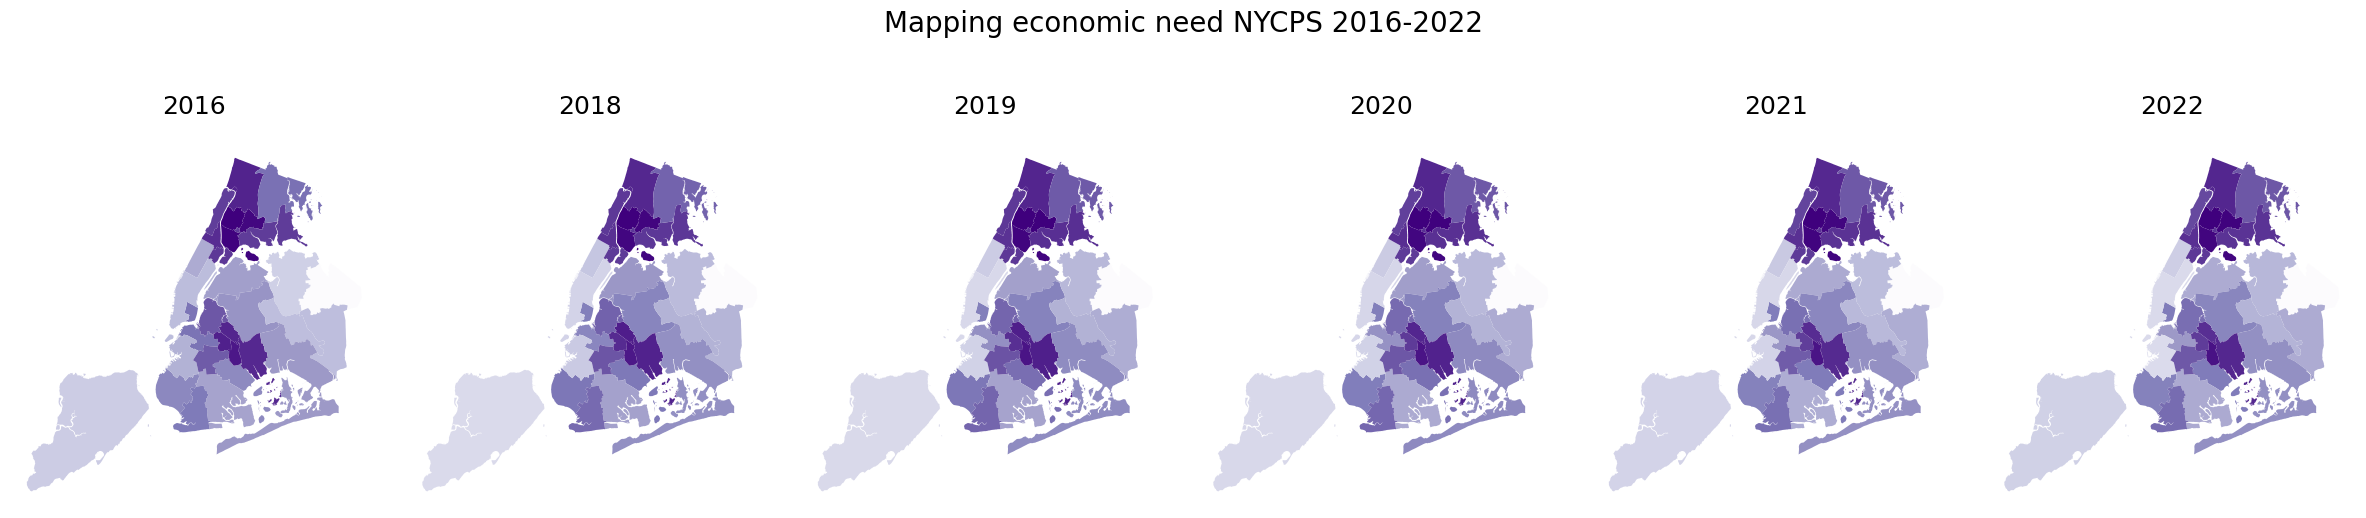

In [26]:

def plot_year(ax, data, key_col, title, cmap="Blues"):
    sns.set_context('talk')
    
    ax.set_title(title, pad=20)
    ax.axis('off')
    _ = data.plot(ax=ax, column=key_col, cmap=cmap, legend=False)


def plot_change(key_col, df, title, cmap):
    years = sorted(df.ay.unique())
    fig, axs = plt.subplots(1, len(years), figsize=(4*len(years), 6))
    for y, ax in zip(years, axs):
        mean_data = df[df.ay == y].groupby("district").agg({key_col: "mean"}).reset_index()
        data = districts.merge(mean_data, on="district", how="inner")
        plot_year(ax, data, key_col, str(y), cmap)


    fig.suptitle(f'{title} {years[0]}-{years[-1]}', fontsize=20)
    fig.tight_layout()
    plt.show()

plot_change("ell_pct", df, "Concentration of new English speaking students NYCPS", cmap="Blues")
plot_change("ell_pct", df, "Concentration of students with disabilities NYCPS", cmap="Greens")
plot_change("eni", df, "Mapping economic need NYCPS", cmap="Purples")